In [0]:
7 !pip install catboost
!pip install category-encoders

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import catboost
%matplotlib inline

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c intercampusai2019

  0% 0.00/242k [00:00<?, ?B/s]
100% 242k/242k [00:00<00:00, 85.4MB/s]
  0% 0.00/541k [00:00<?, ?B/s]
100% 541k/541k [00:00<00:00, 76.5MB/s]
  0% 0.00/234k [00:00<?, ?B/s]
100% 234k/234k [00:00<00:00, 74.7MB/s]


In [0]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
dataset = pd.read_csv('train.csv')

In [0]:
Zone1 = ['BENUE', 'KOGI', 'KWARA', 'NASSARAWA', 'NIGER', 'PLATEAU', 'FCT']
Zone2 = ['ADAMAWA', 'BAUCHI', 'BORNO', 'GOMBE', 'TARABA', 'YOBE']
Zone3 = ['JIGAWA', 'KADUNA', 'KANO', 'KATSINA', 'KEBBI', 'SOKOTO', 'ZAMFARA']
Zone4 = ['ABIA', 'ANAMBRA', 'EBONYI', 'ENUGU', 'IMO']
Zone5 = ['AKWA IBOM', 'BAYELSA', 'CROSS RIVER', 'RIVERS', 'DELTA', 'EDO']
Zone6 = ['EKITI', 'LAGOS', 'OGUN', 'ONDO', 'OSUN', 'OYO']

zone = {}
for i in dataset['State_Of_Origin'].unique():
  zone[i] = None

for key in zone.keys():
  if key in Zone1:
    zone[key] = 'Zone1'
  elif key in Zone2:
    zone[key] = 'Zone2'
  elif key in Zone3:
    zone[key] = 'Zone3'
  elif key in Zone6:
    zone[key] = 'Zone6'
  elif key in Zone5:
    zone[key] = 'Zone5'
  elif key in Zone4:
    zone[key] = 'Zone4'
  else:
    print("No zone found", key)
    
dataset['Zones'] = dataset['State_Of_Origin'].map(zone)

In [0]:
dataset.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Zones
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0,Zone4
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0,Zone4
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0,Zone3
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0,Zone1
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0,Zone5


In [0]:
dataset['RecruitedAge'] = dataset['Year_of_recruitment'] - dataset['Year_of_birth']
dataset['CurrentAge'] = 2019 - dataset['Year_of_birth']
dataset['Length_of_service'] = 2019 - dataset['Year_of_recruitment']
dataset.head(5)

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Zones,RecruitedAge,CurrentAge,Length_of_service
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0,Zone4,25,33,8
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0,Zone4,24,28,4
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0,Zone3,25,32,7
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0,Zone1,27,37,10
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0,Zone5,22,29,7


In [0]:
dataset=pd.merge(dataset,dataset[['State_Of_Origin','Division',
                            'Training_score_average']].groupby(['State_Of_Origin','Division']).mean(),how='left',on=['State_Of_Origin','Division'])
dataset=dataset.rename(columns={'Training_score_average_x':'Training_score_average','Training_score_average_y':'mean_org_div'})
dataset['new_trng_score_avg'] = dataset['Training_score_average'] / dataset['mean_org_div']
dataset.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not,Zones,RecruitedAge,CurrentAge,Length_of_service,mean_org_div,new_trng_score_avg
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0,Zone4,25,33,8,42.335907,0.968445
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0,Zone4,24,28,4,52.536388,0.989790
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0,Zone3,25,32,7,42.236264,0.994406
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0,Zone1,27,37,10,42.233202,0.994478
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0,Zone5,22,29,7,76.239437,1.009976


In [0]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 0 to 38311
Data columns (total 25 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

In [0]:
dataset.describe()

,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not,RecruitedAge,CurrentAge,Length_of_service,mean_org_div,new_trng_score_avg
count,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000,38312.000000
mean,2.253680,1986.209334,7.698959,2013.139695,0.352996,0.023152,55.366465,0.084595,26.930361,32.790666,5.860305,55.366465,1.000000
std,0.609443,7.646047,3.744135,4.261451,0.477908,0.150388,13.362741,0.278282,5.827495,7.646047,4.261451,12.542770,0.095006
min,2.000000,1950.000000,0.000000,1982.000000,0.000000,0.000000,31.000000,0.000000,15.000000,18.000000,1.000000,40.294118,0.738780
25%,2.000000,1982.000000,5.000000,2012.000000,0.000000,0.000000,43.000000,0.000000,23.000000,27.000000,3.000000,42.372694,0.956681
50%,2.000000,1988.000000,7.500000,2014.000000,0.000000,0.000000,52.000000,0.000000,25.000000,31.000000,5.000000,52.166667,0.991920
75%,2.000000,1992.000000,10.000000,2016.000000,1.000000,0.000000,68.000000,0.000000,29.000000,37.000000,7.000000,62.885246,1.026947
max,11.000000,2001.000000,12.500000,2018.000000,1.000000,1.000000,91.000000,1.000000,60.000000,69.000000,37.000000,78.076923,2.171818


In [0]:
dataset["Qualification"].fillna(dataset["Qualification"].mode()[0], inplace = True)
tr_data = dataset
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38312 entries, 0 to 38311
Data columns (total 25 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          38312 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

Text(0.5, 1.0, 'Covariance heatmap')

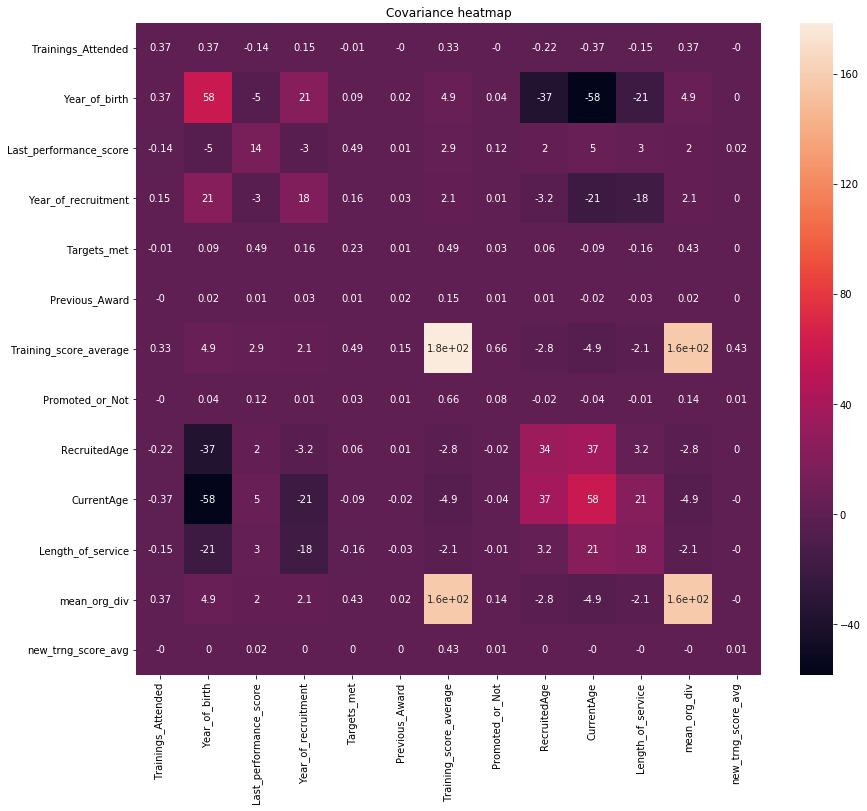

In [0]:
plt.figure(figsize=(14,12))
sns.heatmap(tr_data.cov().round(decimals=2), annot=True)
plt.title("Covariance heatmap")

Text(0.5, 1.0, 'Correlation heatmap')

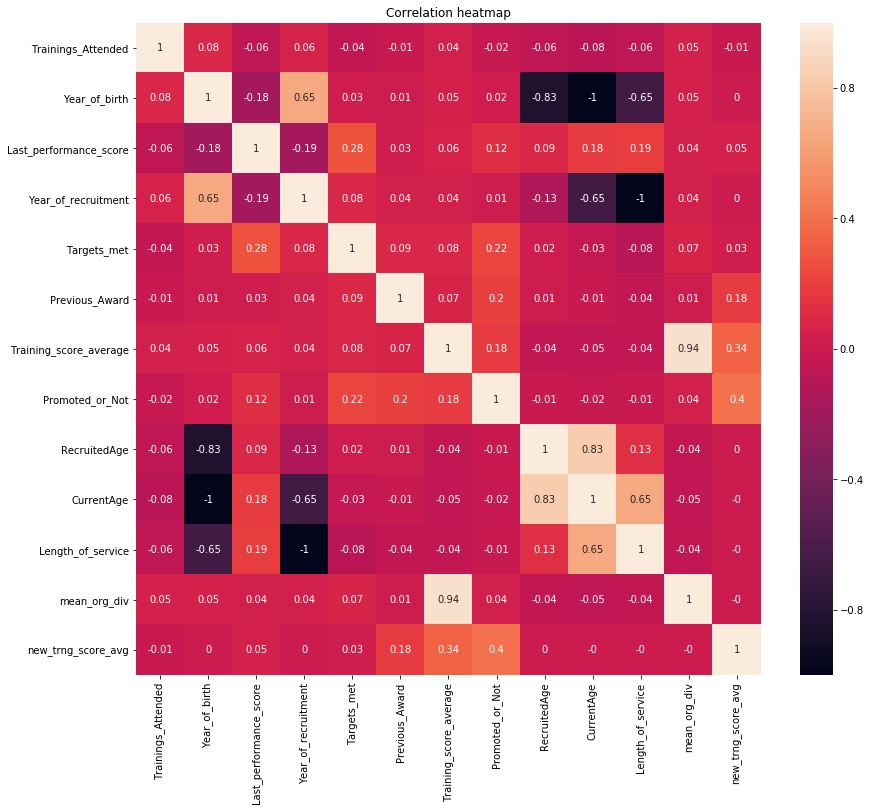

In [0]:
plt.figure(figsize=(14,12))
sns.heatmap(tr_data.corr().round(decimals=2), annot=True)
plt.title("Correlation heatmap")

In [0]:
cols =['Promoted_or_Not', 'EmployeeNo']
X_train = tr_data.drop(cols, axis=1)

In [0]:
X_train.head()

,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Zones,RecruitedAge,CurrentAge,Length_of_service,mean_org_div,new_trng_score_avg
0,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,Zone4,25,33,8,42.335907,0.968445
1,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,Zone4,24,28,4,52.536388,0.989790
2,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,Zone3,25,32,7,42.236264,0.994406
3,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,Zone1,27,37,10,42.233202,0.994478
4,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,Zone5,22,29,7,76.239437,1.009976


In [0]:
col = ['Promoted_or_Not']
y_train = tr_data[col]

In [0]:
cat_cols = ['Division', 'Qualification', 'Gender', 'Channel_of_Recruitment', 'Zones', 'State_Of_Origin', 'Marital_Status', 'Past_Disciplinary_Action', 'Previous_IntraDepartmental_Movement', 'Foreign_schooled']

ce_target = ce.TargetEncoder(cols = cat_cols, smoothing = 5, return_df = True)
X_train = ce_target.fit_transform(X_train, y_train)

In [0]:
cat_features_index = np.where(X_train.dtypes != float)[0]


In [0]:
cat_features_index

array([ 4,  5,  7,  8,  9, 10, 16, 18, 19, 20])

In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

xtrain,xtest,ytrain,ytest = train_test_split(X_train,y_train,train_size=.85,random_state=1234)


from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=400,depth=12, 
                           learning_rate=0.2,
                           eval_metric='F1',
                           l2_leaf_reg=9,one_hot_max_size=50,use_best_model=True,random_seed=42)

model.fit(xtrain,ytrain,cat_features=cat_features_index,eval_set=(xtest,ytest))

0:	learn: 0.4290579	test: 0.3772955	best: 0.3772955 (0)	total: 253ms	remaining: 1m 40s
1:	learn: 0.4402021	test: 0.3855025	best: 0.3855025 (1)	total: 503ms	remaining: 1m 40s
2:	learn: 0.4867925	test: 0.4482759	best: 0.4482759 (2)	total: 742ms	remaining: 1m 38s
3:	learn: 0.4924406	test: 0.4617785	best: 0.4617785 (3)	total: 974ms	remaining: 1m 36s
4:	learn: 0.4933730	test: 0.4658385	best: 0.4658385 (4)	total: 1.22s	remaining: 1m 36s
5:	learn: 0.4952639	test: 0.4687500	best: 0.4687500 (5)	total: 1.46s	remaining: 1m 36s
6:	learn: 0.4971660	test: 0.4704050	best: 0.4704050 (6)	total: 1.69s	remaining: 1m 34s
7:	learn: 0.5017497	test: 0.4751553	best: 0.4751553 (7)	total: 1.92s	remaining: 1m 34s
8:	learn: 0.5072464	test: 0.4791345	best: 0.4791345 (8)	total: 2.17s	remaining: 1m 34s
9:	learn: 0.5075188	test: 0.4829721	best: 0.4829721 (9)	total: 2.4s	remaining: 1m 33s
10:	learn: 0.5115282	test: 0.4876543	best: 0.4876543 (10)	total: 2.64s	remaining: 1m 33s
11:	learn: 0.5128480	test: 0.4869029	best:

In [0]:
test = pd.read_csv('test.csv')

In [0]:
Zone1 = ['BENUE', 'KOGI', 'KWARA', 'NASSARAWA', 'NIGER', 'PLATEAU', 'FCT']
Zone2 = ['ADAMAWA', 'BAUCHI', 'BORNO', 'GOMBE', 'TARABA', 'YOBE']
Zone3 = ['JIGAWA', 'KADUNA', 'KANO', 'KATSINA', 'KEBBI', 'SOKOTO', 'ZAMFARA']
Zone4 = ['ABIA', 'ANAMBRA', 'EBONYI', 'ENUGU', 'IMO']
Zone5 = ['AKWA IBOM', 'BAYELSA', 'CROSS RIVER', 'RIVERS', 'DELTA', 'EDO']
Zone6 = ['EKITI', 'LAGOS', 'OGUN', 'ONDO', 'OSUN', 'OYO']

zone = {}
for i in test['State_Of_Origin'].unique():
  zone[i] = None

for key in zone.keys():
  if key in Zone1:
    zone[key] = 'Zone1'
  elif key in Zone2:
    zone[key] = 'Zone2'
  elif key in Zone3:
    zone[key] = 'Zone3'
  elif key in Zone6:
    zone[key] = 'Zone6'
  elif key in Zone5:
    zone[key] = 'Zone5'
  elif key in Zone4:
    zone[key] = 'Zone4'
  else:
    print("No zone found", key)
    
test['Zones'] = test['State_Of_Origin'].map(zone)

In [0]:
test['RecruitedAge'] = test['Year_of_recruitment'] - test['Year_of_birth']
test['CurrentAge'] = 2019 - test['Year_of_birth']
test['Length_of_service'] = 2019 - test['Year_of_recruitment']

In [0]:
test=pd.merge(test,test[['State_Of_Origin','Division',
                            'Training_score_average']].groupby(['State_Of_Origin','Division']).mean(),how='left',on=['State_Of_Origin','Division'])
test=test.rename(columns={'Training_score_average_x':'Training_score_average','Training_score_average_y':'mean_org_div'})
test['new_trng_score_avg'] = test['Training_score_average'] / test['mean_org_div']
test.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Zones,RecruitedAge,CurrentAge,Length_of_service,mean_org_div,new_trng_score_avg
0,YAK/S/00005,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1976,7.5,2017,0,0,65,FCT,Yes,Married,No,No,1,Zone1,41,43,2,71.882353,0.904255
1,YAK/S/00011,Information Technology and Solution Support,NaN,Male,Direct Internal process,2,1991,0.0,2018,0,0,69,OGUN,Yes,Married,No,No,1,Zone6,27,28,1,72.000000,0.958333
2,YAK/S/00015,Research and Innovation,"MSc, MBA and PhD",Male,Direct Internal process,2,1984,7.5,2012,0,0,76,KANO,Yes,Married,No,No,1,Zone3,28,35,7,76.266667,0.996503
3,YAK/S/00016,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1984,2.5,2009,0,0,52,RIVERS,No,Single,No,No,1,Zone5,25,35,10,52.351220,0.993291
4,YAK/S/00017,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1983,7.5,2014,1,0,69,FCT,Yes,Married,No,No,0,Zone1,31,36,5,71.882353,0.959902


In [0]:
test["Qualification"].fillna(test["Qualification"].mode()[0], inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16496 entries, 0 to 16495
Data columns (total 24 columns):
EmployeeNo                             16496 non-null object
Division                               16496 non-null object
Qualification                          16496 non-null object
Gender                                 16496 non-null object
Channel_of_Recruitment                 16496 non-null object
Trainings_Attended                     16496 non-null int64
Year_of_birth                          16496 non-null int64
Last_performance_score                 16496 non-null float64
Year_of_recruitment                    16496 non-null int64
Targets_met                            16496 non-null int64
Previous_Award                         16496 non-null int64
Training_score_average                 16496 non-null int64
State_Of_Origin                        16496 non-null object
Foreign_schooled                       16496 non-null object
Marital_Status                         164

In [0]:
cols =['EmployeeNo']
X_test = test.drop(cols, axis=1)

In [0]:
X_test = ce_target.transform(X_test)

In [0]:
pred = model.predict(X_test)
pred = pred.astype(np.int)

In [0]:
solution = pd.DataFrame({'EmployeeNo':test['EmployeeNo'],'Promoted_or_Not':pred})

In [0]:
solution.to_csv('solution.csv',index=False)